# LSTM v.s. Time Series Forecasting on Seattle Bicycle Usage

In this notebook, I would like to explore how Recurrent Neural Networks (RNN), i.e., Long-Short Term Memory (LSTM), performs compared with traditional time series modeling. The below models will be implemented:

1. LSTM

2. Moving average

3. Simple Exponential Smoothing

4. Holt-Winter Exponential Smoothing

5. SARIMA

6. SARIMAX

## About Data

The data records the number of bikes that cross the Fremont bridge using the pedestrian/bicycle pathways since 2012.

Data Provided by: City of Seattle

Data source: https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k

In [4]:
# import library
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import matplotlib.pyplot as plt
from pyramid.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
import holidays
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

np.random.seed(1337) # for reproducibility
plt.rcParams["figure.figsize"] = (16,8)

In [6]:
# As of Aug 2019, the CSV can be downloaded as follows:
#!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD
data = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
data.head()

,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,
2015-02-24 02:00:00,3.0,3.0
2019-01-01 00:00:00,0.0,9.0
2019-01-01 01:00:00,2.0,22.0
2016-02-15 00:00:00,3.0,3.0
2019-01-01 02:00:00,1.0,11.0


## EDA

For convenience, I'll further process this dataset by shortening the column names and adding a "Total" column.


In [7]:
data.columns = ['West', 'East']
data['Total'] = data.eval('West + East')
data.dropna().describe()

,West,East,Total
count,59823.000000,59823.000000,59823.000000
mean,52.619795,60.262324,112.882119
std,67.734326,87.871363,143.101423
min,0.000000,0.000000,0.000000
25%,6.500000,7.000000,15.000000
50%,29.000000,30.000000,61.000000
75%,70.000000,73.000000,147.000000
max,698.000000,850.000000,1097.000000


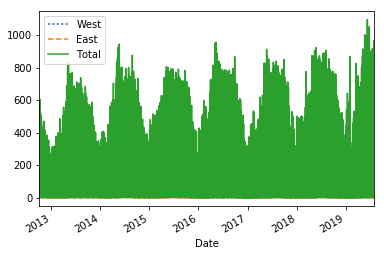

In [9]:
data.plot(style = [':', '--', '-'])

For simplicity, let's aggregate to weekly level.

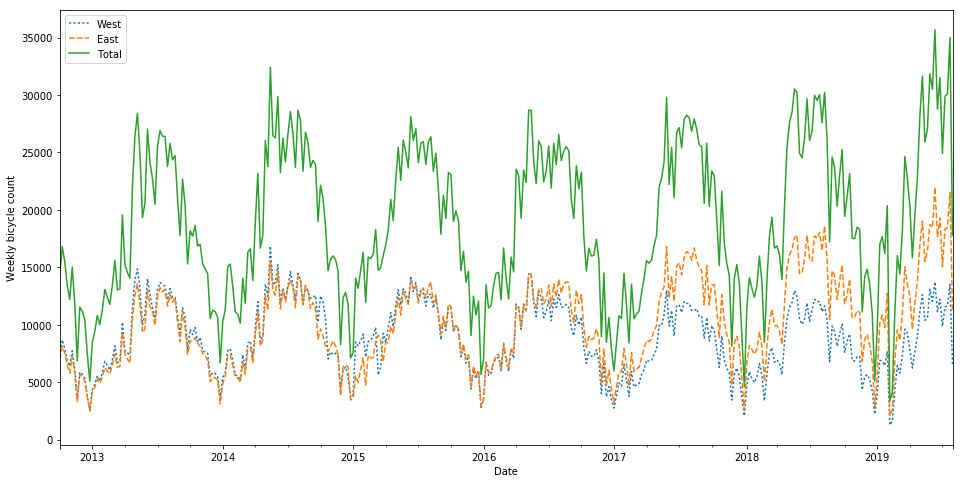

In [29]:
weekly = pd.DataFrame(data.resample('W').sum())
weekly.plot(style=[':', '--', '-'])
plt.ylabel('Weekly bicycle count')

weekly = weekly.loc[:, 'Total':]

## LSTM

### Data prepocessing

In [12]:
# split into train & test
size = int(len(weekly) * .8)
train, test = weekly[0:size], weekly[size:len(weekly)]

# convert training set to array
training_set = train.iloc[:, 0:1].values

# Feature Scaling: X_scaled = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [13]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping to 3 dimensions: batch_size (no. of observations), timesteps, input_dim (no. of predictors)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### Building the RNN

In [14]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation: 50 neurons
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2)) # 20% of neurons to be dropped out to avoid overfit

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2)) 

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
225/225 [==============================] - 6s 26ms/step - loss: 0.1585
Epoch 2/100
225/225 [==============================] - 2s 9ms/step - loss: 0.0706
Epoch 3/100
225/225 [==============================] - 2s 9ms/step - loss: 0.0671
Epoch 4/100
225/225 [==============================] - 2s 9ms/step - loss: 0.0538
Epoch 5/100
225/225 [==============================] - 2s 10ms/step - loss: 0.0502
Epoch 6/100
225/225 [==============================] - 2s 10ms/step - loss: 0.0473
Epoch 7/100
225/225 [==============================] - 2s 8ms/step - loss: 0.0451
Epoch 8/100
225/225 [==============================] - 2s 9ms/step - loss: 0.0460
Epoch 9/100
225/225 [==============================] - 2s 10ms/step - loss: 0.0328
Epoch 10/100
225/225 [==============================] - 2s 10ms/step - loss: 0.0161
Epoch 11/100
225/225 [==============================] - 2s 11ms/step - loss: 0.0224
Epoch 12/100
225/225 [==============================] - 3s 12ms/step - loss: 0.0198
Epoch 

225/225 [==============================] - 2s 8ms/step - loss: 0.0130
Epoch 100/100
225/225 [==============================] - 2s 9ms/step - loss: 0.0112


### Predict & visualize

I achieved 14.7% MAPE in prediction and LSTM captures the trend properly.

In [15]:
# Getting the real units sold in test set
real = test.iloc[:, 0:1].values

# Getting the predicted value
inputs = weekly[len(weekly) - len(test) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

# create 3D structure for test set
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred = regressor.predict(X_test)

# inverse transformation back to the actual units
pred = sc.inverse_transform(pred)

# MAPE 
abs(real - pred).sum() / real.sum()

0.14681788158710463

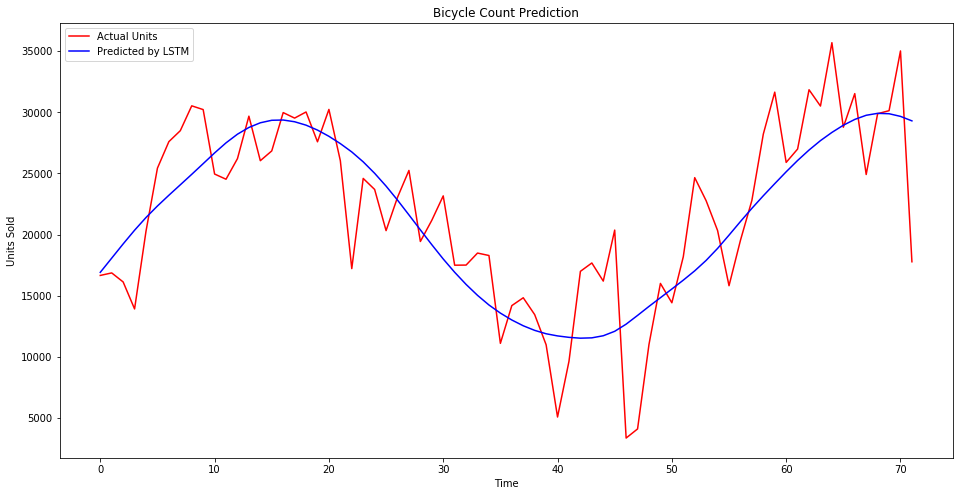

In [30]:
# Visualising the results
plt.plot(real, color = 'red', label = 'Actual Units')
plt.plot(pred, color = 'blue', label = 'Predicted by LSTM')
plt.title('Bicycle Count Prediction')
plt.xlabel('Time')
plt.ylabel('Units Sold')
plt.legend()
plt.show()

### Other models

#### Simple Exponential Smoothing

In [19]:
######### SES ##########
ses = SimpleExpSmoothing(train['Total']).fit().forecast(len(test))
abs(test['Total'] - ses).sum() /test['Total'].sum() # 31.1%

0.3109595617780631

#### Holt-Winter Exponential Smoothing

In [20]:
########## HWES #########
hwes = ExponentialSmoothing(train['Total'], seasonal='add', seasonal_periods = 52).fit().forecast(len(test))
abs(test['Total'] - hwes).sum() /test['Total'].sum() # 13.5%

0.13512515159536886

#### Moving Average

In [21]:
history = train['Total'].tolist()

for i in range(len(test)):
    ma = sum(history[-4:]) / 4
    history.append(ma)

ma = history[-len(test):]
abs(test['Total'] - ma).sum() /test['Total'].sum() # 33.9%

0.3390056020854423

#### SARIMA

In [18]:
### Compare with SARIMA #
autoarima = auto_arima(train, m = 52,
                  trace=True, error_action='ignore',
                  stationary = False, disp=-1,stepwise=True,
                  suppress_warnings=True)
# model parameter: (2,0,2) * (1,0,1,52)

sarima = autoarima.predict(len(test))
abs(test['Total'] - sarima).sum() /test['Total'].sum() # 22.1%

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 52); AIC=5349.079, BIC=5378.299, Fit time=14.270 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=5789.647, BIC=5796.952, Fit time=0.013 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 52); AIC=5515.199, BIC=5529.809, Fit time=5.033 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 1, 52); AIC=5359.641, BIC=5385.208, Fit time=3.729 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 2, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 52); AIC=5375.794, BIC=5397.709, Fit time=0.178 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 2, 52); AIC=nan, BIC=nan, 

0.22093986914505515

#### SARIMAX

In [23]:
# Get US holiday data from 2012 to 2019
dat= list()
holiday = list()
for date, name in sorted(holidays.US(state='CA', 
                                     years=[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]).items()):
    dat.append(date)
    holiday.append(name)

holidays = pd.DataFrame(list(zip(dat, holiday)), columns = ['Date', 'Holiday'])
holidays['Date'] = holidays['Date'].astype('datetime64')

# merge holiday table with main table
daily = data.resample('D')['Total'].sum().reset_index()
daily = daily.merge(holidays, how = 'left', on = 'Date').fillna(0)
daily['Count'] = 1
daily_pivot = pd.pivot_table(daily, index = ['Date', 'Total'], 
                             values = 'Count', columns = ['Holiday'], fill_value = 0).reset_index()
daily_pivot.drop(columns = 0, axis = 1, inplace = True)

# aggregate to weekly level
daily_pivot = daily_pivot.set_index('Date')
weekly_exog = daily_pivot.resample('W').sum()

# split into train and test
size = int(len(weekly_exog) * .8)
train2, test2 = weekly_exog[0:size], weekly_exog[size:len(weekly_exog)]

# fit model 
sarimax = auto_arima(train2.iloc[:, :1], m = 52, exogenous = train2.iloc[:, 1:],
                  trace=True, error_action='ignore',
                  stationary = False, disp=-1,stepwise=True,
                  suppress_warnings=True).predict(len(test), exogenous = test2.iloc[:, 1:])

abs(test['Total'] - sarimax).sum() /test['Total'].sum() # 21.3%

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 52); AIC=5906.243, BIC=6001.208, Fit time=38.618 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=6081.596, BIC=6154.646, Fit time=0.075 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 52); AIC=5968.161, BIC=6048.515, Fit time=15.949 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 52); AIC=5973.612, BIC=6053.966, Fit time=6.194 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 1, 52); AIC=5930.090, BIC=6021.402, Fit time=37.330 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 1, 52); AIC=5905.177, BIC=6003.794, Fit time=202.750 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 0, 52); AIC=5905.757, BIC=6000.722, Fit time=140.340 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 2, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 0, 52); AIC=5904.205, BIC=5995.517, Fit time=23.002 seconds
Fit ARIMA: order=(1, 0, 2) seaso

0.21254625559453416

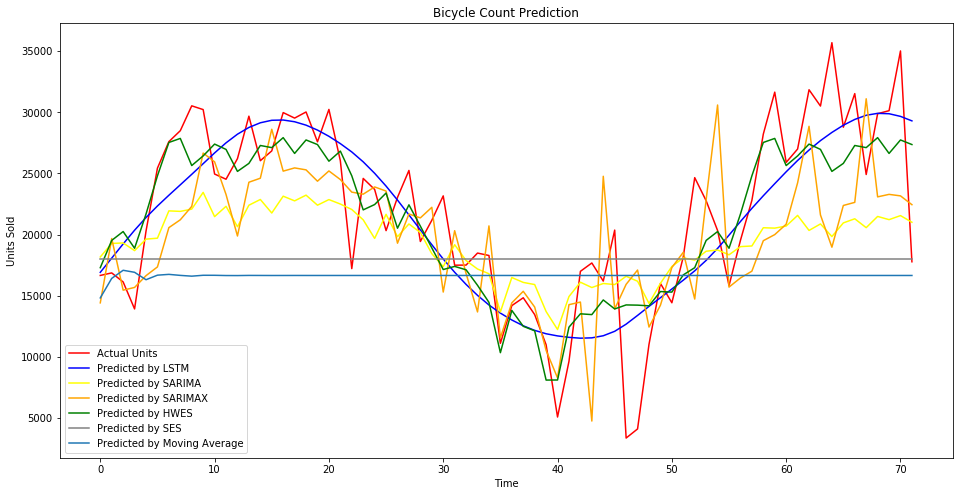

In [28]:
# Visualising the results
plt.plot(real, color = 'red', label = 'Actual Units')
plt.plot(pred, color = 'blue', label = 'Predicted by LSTM')
plt.plot(sarima, color = 'yellow', label = 'Predicted by SARIMA')
plt.plot(sarimax, color = 'orange', label = 'Predicted by SARIMAX')
plt.plot(hwes.values, color = 'green', label = 'Predicted by HWES')
plt.plot(ses.values, color = 'gray', label = 'Predicted by SES')
plt.plot(ma,label = 'Predicted by Moving Average')
plt.title('Bicycle Count Prediction')
plt.xlabel('Time')
plt.ylabel('Units Sold')
plt.legend()
plt.show()